In [81]:
# General
import numpy as np
import pandas as pd
import os
import jumpmodels.utils

# For loading data and feature engineering
from feature_25 import DataLoader, MergedDataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd 

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt

In [103]:
# Import data
# -------------------------

# Define file path
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\data"
factor_file = os.path.join(directory, "factor_data.csv")
market_file = os.path.join(directory, "market_data.csv")

# Use DataLoader to generate features when we use factor and market data
data = MergedDataLoader(
    factor_file=factor_file,
    market_file=market_file,
    ver="v2",
    factor_col="MTUM"  # specify which column in factor_data.csv is your factor return
).load(start_date="2002-05-31", end_date="2025-02-24")

# Ensure all attributes have the same index before filtering
common_index = data.X.index.intersection(data.ret_ser.index).intersection(data.market_ser.index)
data.X = data.X.loc[common_index]
data.ret_ser = data.ret_ser.loc[common_index]
data.market_ser = data.market_ser.loc[common_index]

# Identify and drop dates where returns are exactly 0.0
zero_return_dates = data.ret_ser[data.ret_ser == 0.0].index

# Drop from all attributes to maintain alignment
data.X = data.X.drop(zero_return_dates, errors='ignore')
data.ret_ser = data.ret_ser.drop(zero_return_dates, errors='ignore')
data.market_ser = data.market_ser.drop(zero_return_dates, errors='ignore')  # Ensure market returns match


# print("Daily returns:", data.ret_ser)
# print("Engineered features:", data.X)

# factor_data = pd.read_csv(factor_file, parse_dates=["Date"], index_col="Date")

# Plot cumulative returns
# plot_cumret(factor_data["IWF"])
# plt.show()


In [104]:
# Train/test split
# -------------------------

train_start, test_start = "2002-05-31", "2018-01-01" #actual start date of training will be in August due to 63 trading days required for EWMA
# filter dates
X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
X_test = filter_date_range(data.X, start_date=test_start)
# print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

# Preprocessing
# -------------------------

# Clip the data within 3 standard deviations to mitigate the impact of outliers and standardize the clipped data (zero mean and unit variance)
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()
# fit on training data
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))
# transform the test data
X_test_processed = scalar.transform(clipper.transform(X_test))

Training starts at: 2002-08-28 00:00:00 and ends at: 2017-12-29 00:00:00
Testing starts at: 2018-01-02 00:00:00 and ends at: 2025-02-24 00:00:00


In [109]:
# -------------------------
# Fit the Sparse Jump Model
# -------------------------

kpa_sq = 9
lmda = 10


# **Final Model Training with Best (λ, κ) Values**
best_model = SparseJumpModel(n_components=2, max_feats=kpa_sq, jump_penalty=lmda, cont=False, max_iter=10)
best_model.fit(X_train_processed, data.ret_ser, sort_by="cumret")



SparseJumpModel(jump_penalty=10, max_feats=9, max_iter=10)

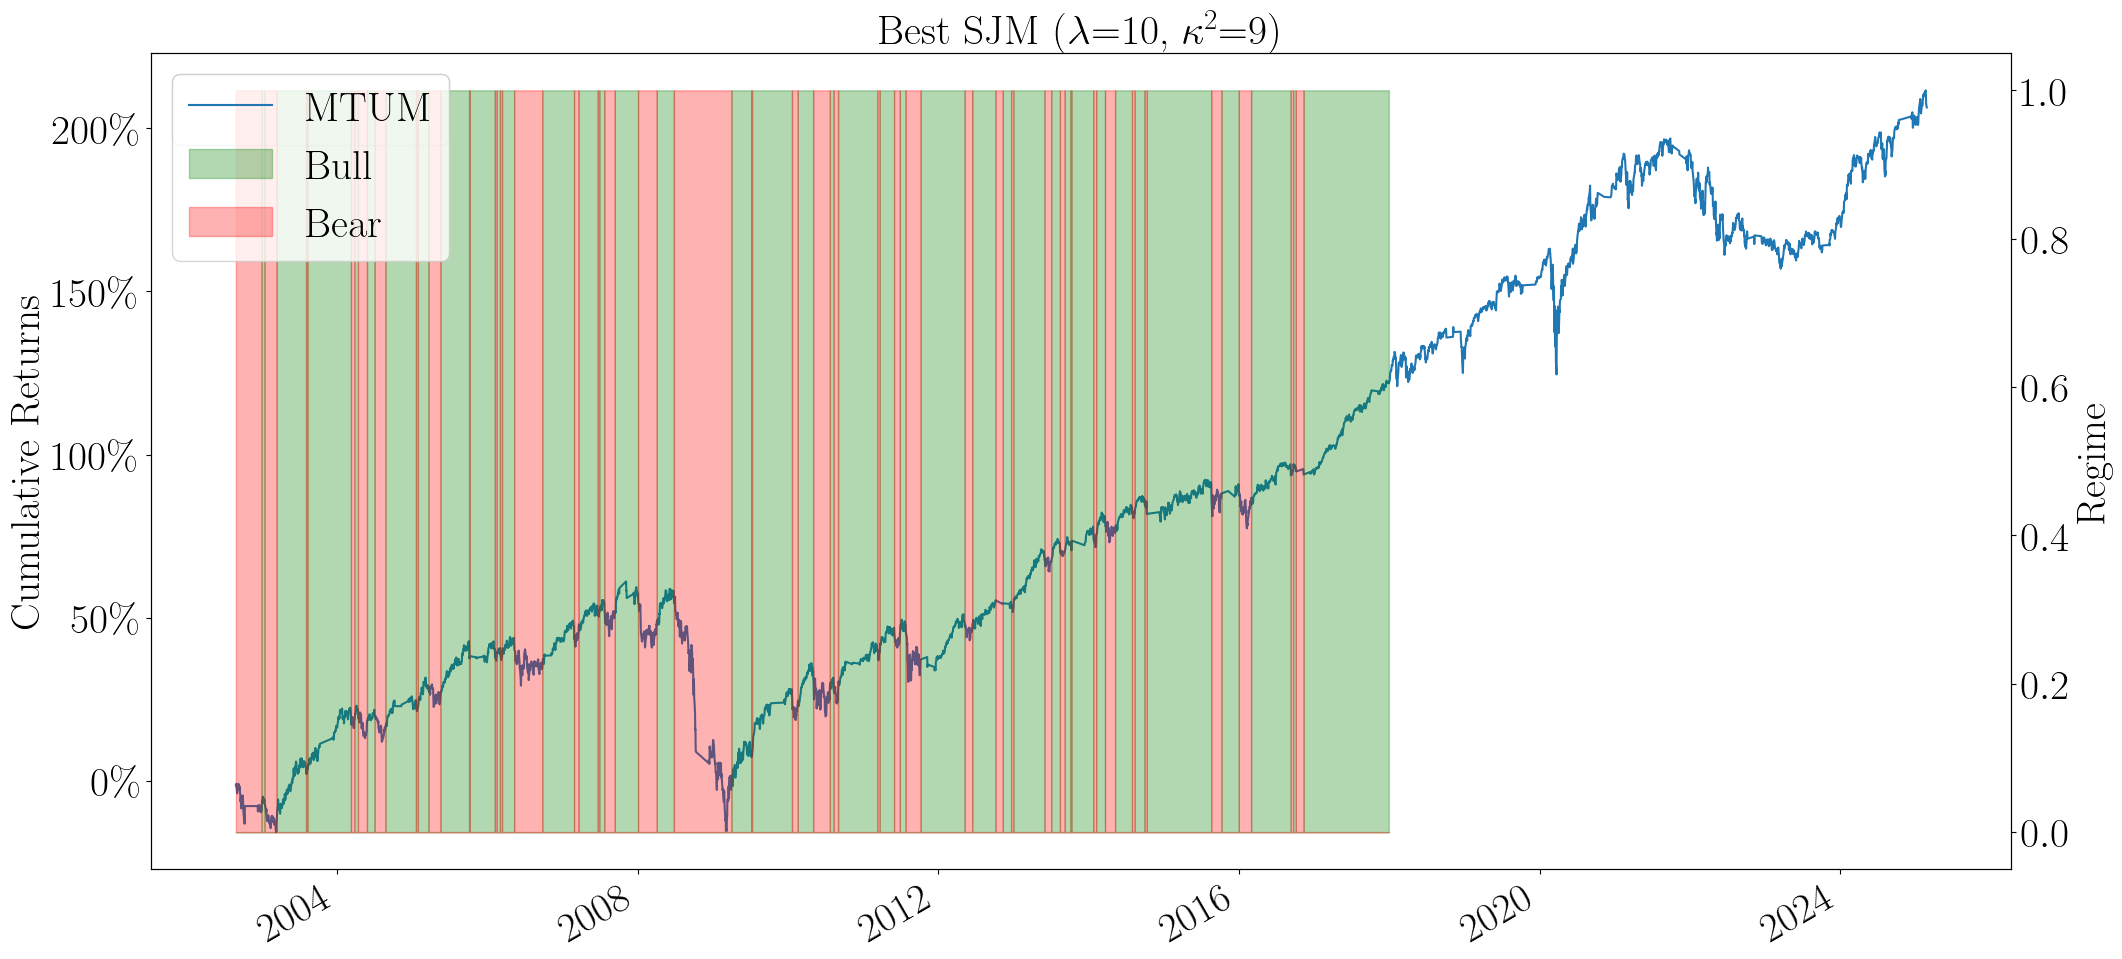

In [110]:
# **Predict and Plot Results**

# factor_data = pd.read_csv(factor_file, parse_dates=["Date"], index_col="Date")

predicted_states = best_model.predict(X_train_processed)

# print(predicted_states.head())
# print(factor_data["VLUE"].head())
# print(predicted_states.tail())
# print(factor_data["VLUE"].tail())

ax, ax2 = plot_regimes_and_cumret(predicted_states, data.ret_ser)
ax.set(title=f"Best SJM ($\\lambda$={lmda}, $\\kappa^2$={kpa_sq})")
plt.show()

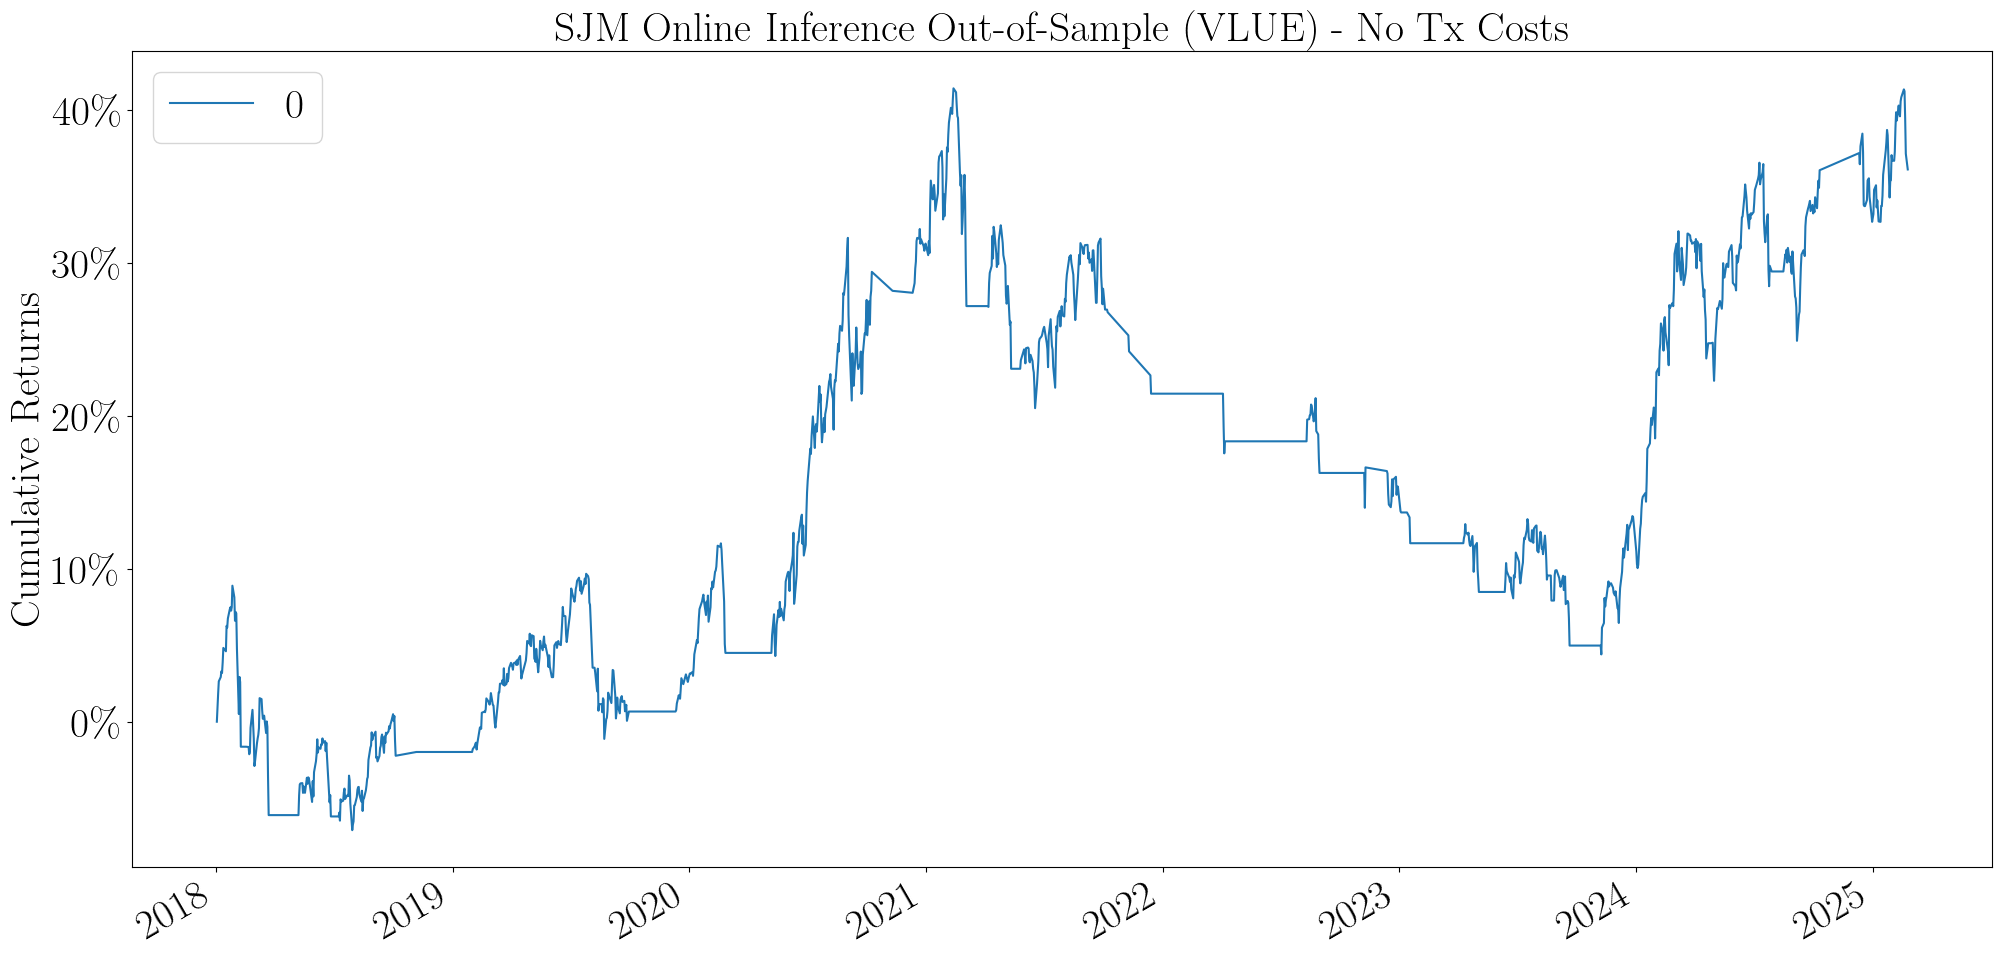

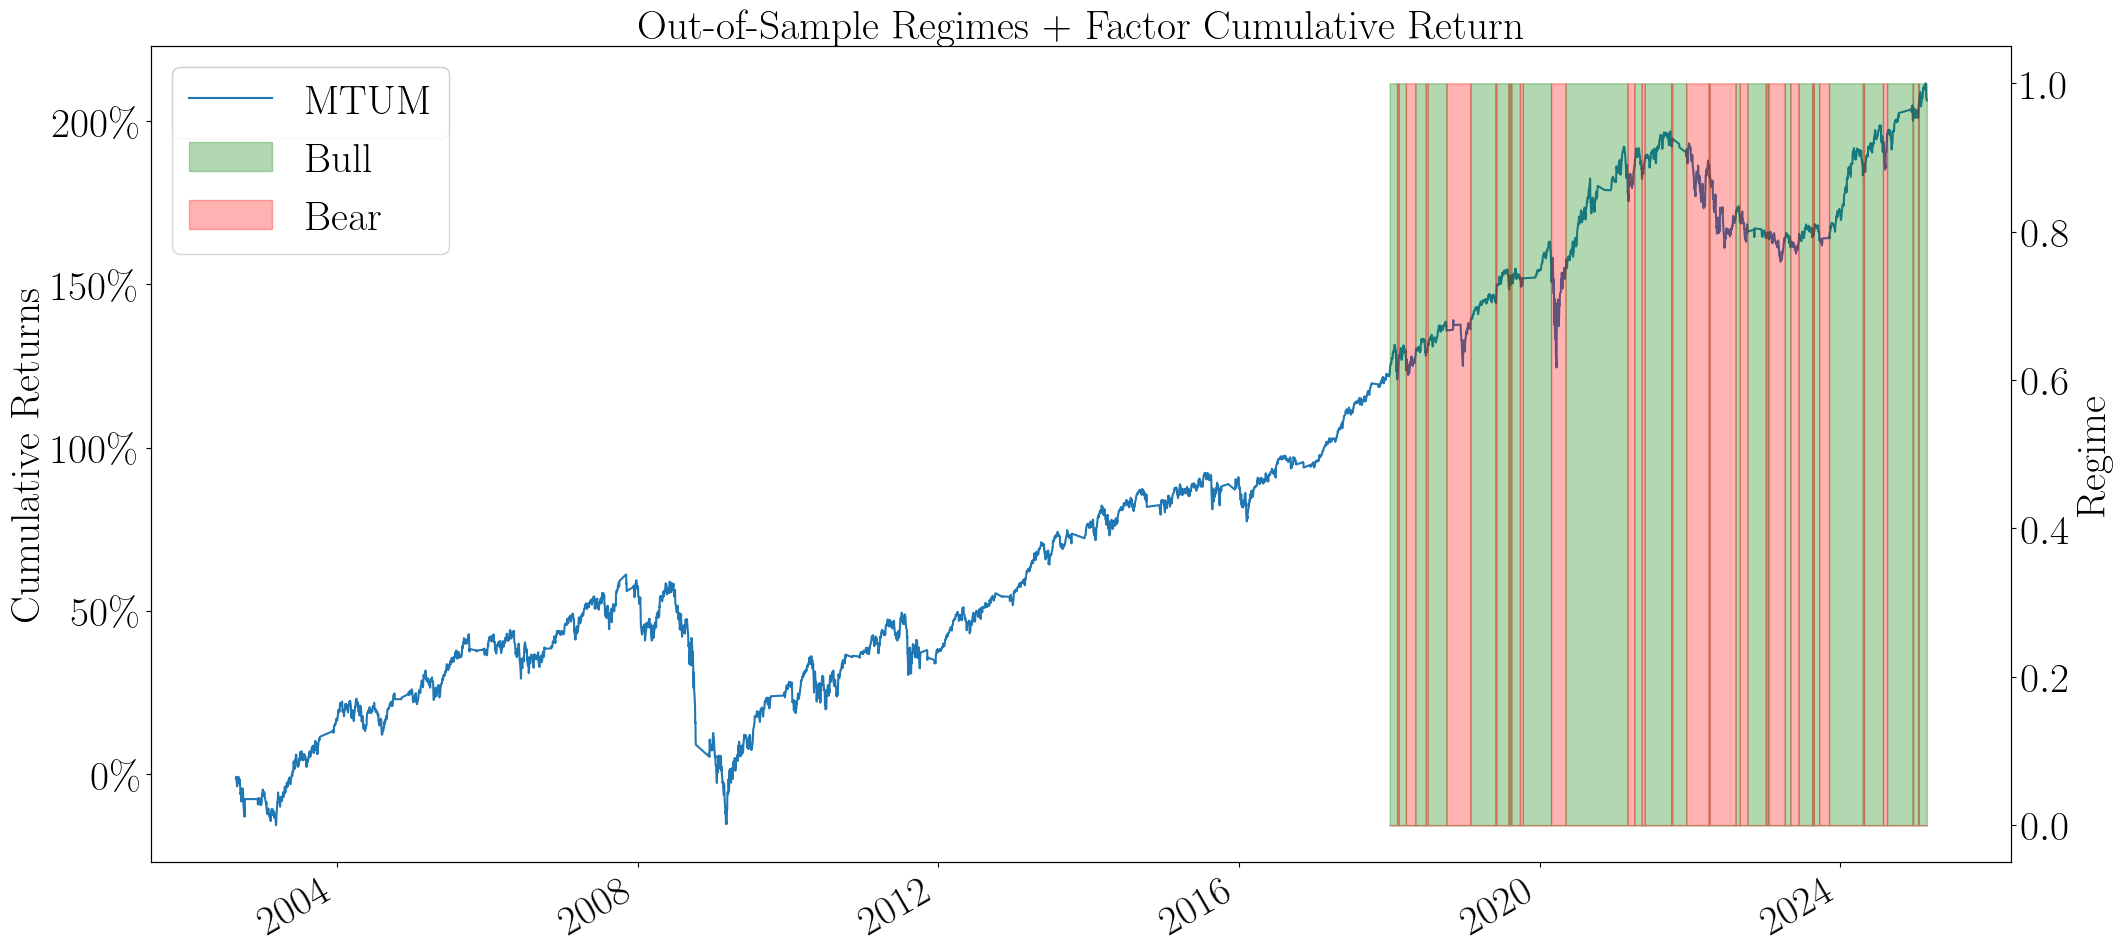


SJM Online Inference Strategy Stats (No Tx Costs):
Annualized Return: 5.99%
Annualized Vol:    14.06%
Sharpe Ratio:      0.43


Buy-and-Hold Strategy Stats (No Tx Costs):
Annualized Return: 14.03%
Annualized Vol:    22.91%
Sharpe Ratio:      0.61



In [111]:
# =============================
# Out-of-Sample Online Inference Strategy (No Tx Costs)
# =============================

# 1) Use best_model on the TEST set
states_test = best_model.predict_online(X_test_processed)
# states_test is an array of 0/1 with the same length as X_test_processed.index
states_test = pd.Series(states_test, index=X_test_processed.index, name="SJM_State")

# 2) If yesterday's state == 0 => go long 1.0 x factor, else 0.0
#    factor daily return is data.ret_ser
#    We only have test period returns at data.ret_ser.loc[X_test_processed.index]
test_factor_returns = data.ret_ser.loc[X_test_processed.index]  # factor daily returns (VLUE)
# Shift the state signal by one day to use yesterday's state; fill first day with 0
position = (states_test.shift(1) == 0).astype(float).fillna(0)

# 3) Strategy daily returns (NO transaction costs)
strat_daily_ret = position * test_factor_returns

plot_cumret(strat_daily_ret)
plt.title("SJM Online Inference Out-of-Sample (VLUE) - No Tx Costs")
plt.show()

# 4) Also plot the out-of-sample regimes side by side with the factor returns
fig, ax = plot_regimes_and_cumret(states_test, data.ret_ser)
ax.set_title("Out-of-Sample Regimes + Factor Cumulative Return")
plt.show()

# 5) Check summary stats for SJM Online Inference Strategy
ann_ret = strat_daily_ret.mean() * 252
ann_vol = strat_daily_ret.std() * (252**0.5)
sharpe = ann_ret / ann_vol if ann_vol > 1e-12 else 0.0

print("\n==============================")
print("SJM Online Inference Strategy Stats (No Tx Costs):")
print(f"Annualized Return: {ann_ret:.2%}")
print(f"Annualized Vol:    {ann_vol:.2%}")
print(f"Sharpe Ratio:      {sharpe:.2f}")
print("==============================\n")

# =============================
# Buy-and-Hold Strategy (Always Long)
# =============================

# For a buy-and-hold strategy, we are always fully invested.
buy_hold_daily_ret = test_factor_returns  # simply 1.0 * test_factor_returns

# Compute summary stats for Buy-and-Hold
bh_ann_ret = buy_hold_daily_ret.mean() * 252
bh_ann_vol = buy_hold_daily_ret.std() * (252**0.5)
bh_sharpe = bh_ann_ret / bh_ann_vol if bh_ann_vol > 1e-12 else 0.0

print("\n==============================")
print("Buy-and-Hold Strategy Stats (No Tx Costs):")
print(f"Annualized Return: {bh_ann_ret:.2%}")
print(f"Annualized Vol:    {bh_ann_vol:.2%}")
print(f"Sharpe Ratio:      {bh_sharpe:.2f}")
print("==============================\n")


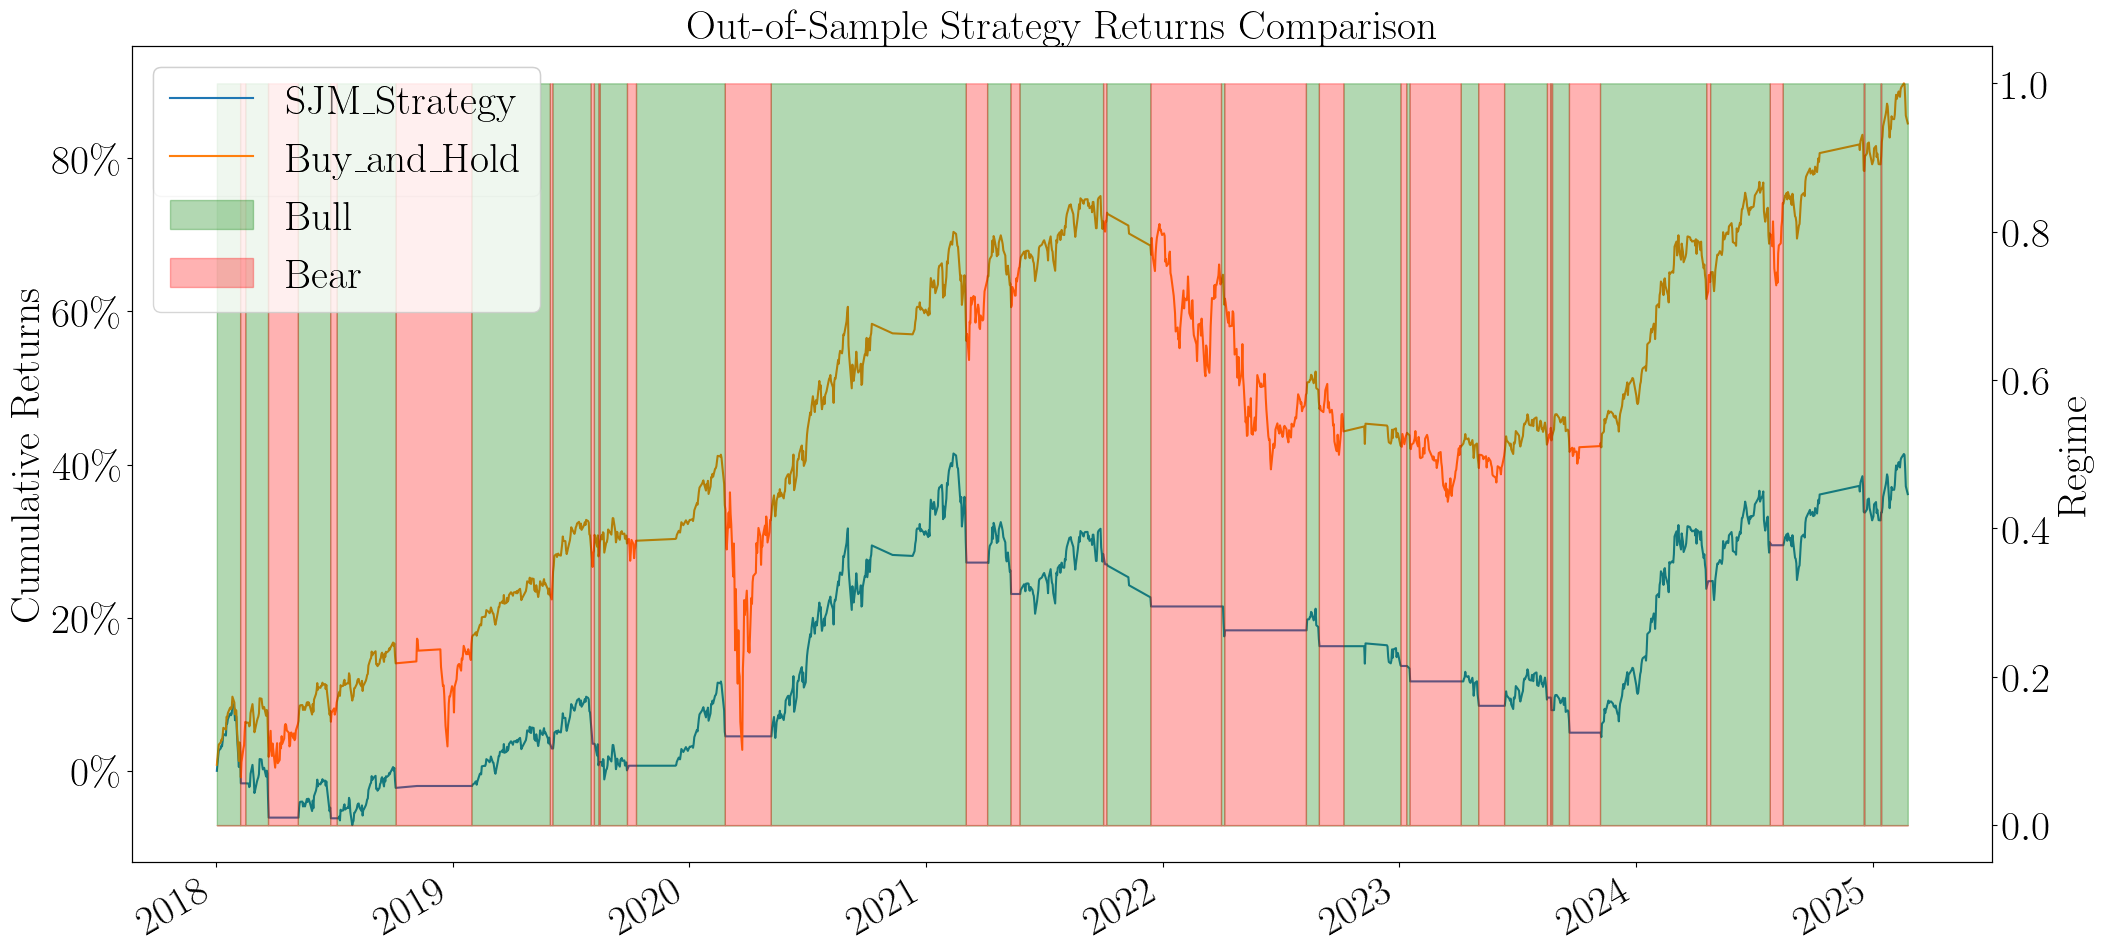

In [112]:
# Combine the strategy returns and the buy-and-hold returns into a single DataFrame
combined_returns = pd.concat([
    strat_daily_ret.rename("SJM_Strategy"),
    buy_hold_daily_ret.rename("Buy_and_Hold")
], axis=1)

# Plot cumulative returns for both strategies alongside the regimes
fig, ax = plot_regimes_and_cumret(states_test, combined_returns)
ax.set_title("Out-of-Sample Strategy Returns Comparison")
plt.show()


In [88]:
#jupyter nbconvert --to script sparseJM_fixed_hyper.ipynb